In [1]:
# Module import
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
#reset the graph
tf.reset_default_graph() 

In [3]:
# data load
f1 = open ('traindata.txt','r') #open : read 모드
X0 =[]
X0 =[line.split()for line in f1]

# 공백 기준으로 리스트로 만들기 : shape -> (5000,784) 784구조(28*28)가 5000개 있음
# 줄이 바뀔 때 split.

f1.close()
Xr=np.array(X0, dtype=np.float32)

In [4]:
#위와 동일 y는 label 지정.

f1 = open ('trainlabels.txt','r')
y =[]
y =[ line.split()for line in f1]
f1.close()
y=np.array(y, np.int64)

In [8]:
print(Xr.shape)
print(y.shape)

(5000, 784)
(5000, 1)


In [10]:
# 10개의 0이 포함되어 있는 구조를 sample size 만큼 만듬.
Yr=np.zeros((sample_size,10))
# shape => (5000,10)

In [11]:
for ii in range(sample_size):
    Yr[ii, y[ii]]=1
    
# EX) ii가 0일때
# Yr[0] => Yr의 첫번째 행을 추출
# y[0] => y의 0번째 원소 즉, 8을 의미
# 즉, Yr[0, y[0]] = 1 -> Yr[0,8] 0번째 행에서 9번째 원소를 택해서 1로 바꾸는 것.

In [12]:
Yr # 5000개의 행별로 라벨 값의 위치에 1을 삽입

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [13]:
#sample size는 Xr의 크기만큼 지정 = 5000
sample_size=Xr.shape[0]  #=5000
x_dim = Xr.shape[1]  #=784
y_dim=Yr.shape[1]  #=10
tf.set_random_seed(1) #the graph-level random seed
learning_rate = 0.0001
batch_size = 100 # 배치 크기 : 100
z_dim = 100  # Generator Net의 차원을 지정.
epochs = 500 # 에포크 수
g_hidden_size = 128 
d_hidden_size = 128 
alpha=0.1 # parameter for Leaky ReLu, alpha=0 ~ ReLu
# Leaky Relu : “dying ReLU” 현상을 해결하기 위해 제시된 함수
# . ReLU는 x<0인 경우 항상 함수값이 0이지만, Leaky ReLU는 작은 기울기를 부여한다.

In [14]:
#드롭아웃 확률와 플레이스홀더 지정.
keep_prob = tf.placeholder(tf.float32,name='keep_prob')
Y = tf.placeholder(tf.float32, shape=[None, y_dim], name='Y') # 첫번째 추가된 코드.

### 2개의 신경망 층을 사용했음.

### Generator Net과 Discriminator Net 

# Discriminator Net  
X = tf.placeholder(tf.float32, shape=[None, x_dim], name='X')
D_W1=tf.get_variable('D_W1',shape=[x_dim+y_dim,d_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
D_b1 = tf.Variable(tf.random_normal([d_hidden_size]), name='D_b1')
D_W2 = tf.get_variable('D_W2',shape=[d_hidden_size,1],initializer=tf.contrib.layers.xavier_initializer())
D_b2 = tf.Variable(tf.random_normal([1]), name='D_b2')
theta_D = [D_W1, D_W2, D_b1, D_b2]

#########################################
### another version #####################
# Discriminator Net 
# X = tf.placeholder(tf.float32, shape=[None, 784], name='X')
# D_W1 = tf.Variable(xavier_init([784, 128]), name='D_W1')
# D_b1 = tf.Variable(tf.zeros(shape=[128]), name='D_b1')
# D_W2 = tf.Variable(xavier_init([128, 1]), name='D_W2')
# D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')
# theta_D = [D_W1, D_W2, D_b1, D_b2]
##########################################

# Generator Net
Z = tf.placeholder(tf.float32, shape=[None, z_dim], name='Z')
G_W1 = tf.get_variable('G_W1',shape=[z_dim+y_dim,g_hidden_size],initializer=tf.contrib.layers.xavier_initializer())
# 기존에는 shape[100,128]을 사용했지만 위코드에선 shape -> [110,128] 
# z_dim+y_dim 왜 더하나????

# D(x,y)와 G(z, y)에 대한 입력 값이 원본 GAN과 다르기 때문에 우리는 가중치를 수정해야 한다.
# ->>> 단순히 가중치의 차원을 조정

G_b1 = tf.Variable(tf.zeros(shape=[g_hidden_size]), name='G_b1')

G_W2 = tf.get_variable('G_W2',shape=[g_hidden_size,x_dim],initializer=tf.contrib.layers.xavier_initializer())
# shape -> [128,784]

G_b2 = tf.Variable(tf.zeros(shape=[x_dim]), name='G_b2')
theta_G = [G_W1, G_W2, G_b1, G_b2]

#########################################
### another version #####################
# Generator Net
# Z = tf.placeholder(tf.float32, shape=[None, 100], name='Z')
# G_W1 = tf.Variable(xavier_init([100, 128]), name='G_W1')
# G_b1 = tf.Variable(tf.zeros(shape=[128]), name='G_b1')
# G_W2 = tf.Variable(xavier_init([128, 784]), name='G_W2')
# G_b2 = tf.Variable(tf.zeros(shape=[784]), name='G_b2')

# theta_G = [G_W1, G_W2, G_b1, G_b2]
##########################################

In [15]:
#생성자 정의 : 잡음신호를 입력으로 받아 이미지를 생성.
def generator(z,y): # zy변수가 추가되고 h1에 기존 z가 아닌 zy로 대체되어 들어감. 나머지는 동일.
    with tf.variable_scope('generator'): 
    # Leaky ReLU # 음수인 값 0으로 취함.
        zy=tf.concat([z,y],axis=1) # Concatenate  and y : Concatenate라는 뜻은 사슬처럼 잇다라는 뜻.
                                   # 한 차원을 기준으로 텐서를 이어 붙입니다. axis=1은 열기준.
                                   # t3 shape : [2,3], t4 shape : [2,3] 이면 axis=0 -> shape : [4, 3], axis=1 -> shape : [2,6]
                
                
        h1=tf.matmul(zy, G_W1) + G_b1 #zy와 G_W1의 행렬의 곱.         
        h1 = tf.maximum(alpha*h1, h1)  #(alpha*h1, h1)에서 가장큰값 choice. alpha는 위에어
        h2 = tf.matmul(h1, G_W2) + G_b2
        out = tf.nn.tanh(h2)  # 하이퍼볼릭 탄젠트 함수를 취해 값을 -1에서 1로 만듬.
        return out
    
## 참고 코드.    
# def generator(z):
#     G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
#     G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
#     G_prob = tf.nn.sigmoid(G_log_prob)

#     return G_prob

# def generator(z, y):
#     # Concatenate z and y
#     inputs = tf.concat(concat_dim=1, values=[z, y])

#     G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
#     G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
#     G_prob = tf.nn.sigmoid(G_log_prob)

#     return G_prob

#위의 generator (z)는 100 차원 벡터를 취하고 786 차원의 벡터를 반환합니다.
#이 벡터는 MNIST 이미지 (28x28)입니다. 여기에서 z는 "G (Z)"에 대한 사전 값입니다.
#어떤면에서는 "Pdata"에 대한 이전 공간 간의 매핑을 학습합니다.

#판별자 정의 : 입력된 진짜 이미지와 가짜 이미지를 정확하게 분류.
def discriminator(x,y): # 판별자도 동일하게 xy변수 만들고 h1에 x대신 xy변수를 대입. 나머지는 동일.
    with tf.variable_scope('discriminator'):
    # Leaky ReLU
        xy=tf.concat([x,y],axis=1) 
        h1=tf.matmul(xy, D_W1) + D_b1        
        h1 = tf.maximum(alpha*h1, h1)    
        h1=tf.nn.dropout(h1, keep_prob) # 드롭아웃 : 과적합 회피 - 신경망의 일부 뉴런 생략.
        h2 = tf.matmul(h1, D_W2) + D_b2
        h2=tf.nn.dropout(h2, keep_prob) 
        prob = tf.nn.sigmoid(h2)
        return prob, h2

# discriminator(x,y)는 
# y의 조건이 주어졌을 때 실제 MNIST 이미지의 확률을 나타내는 스칼라를 반환합니다.


#여기에 있는 문제는 새로운 변수 y를 D(X)와 G(z)에 통합하는 방법입니다.
#Conditional Joint를 모델링하려고 할 때 가장 간단한 방법은 두 변수를 연결하는 것입니다.
# 따라서 G (z,y)에서 z와 y를 결합하여 네트워크에 공급합니다. 동일한 절차가 D (X, y)에 적용됩니다.


In [16]:
#모든 네트워크에 매개 변수 y 추가
G_z = generator(Z,Y)
D_real, D_logit_real = discriminator(X,Y)
D_fake, D_logit_fake = discriminator(G_z,Y)

In [17]:
#판별자, 생성자를 위한 비용함수 및 최적화

#생각해 보면, discriminator(X)는 모든 출력을 1로 만들려고합니다.
#정의에 따라 실제 데이터의 확률을 최대화하고 싶습니다.
#discriminator(G_sample)는 모든 출력을 0으로 만들고 싶어하므로 D(G(Z))는 가짜 데이터의 확률을 최소화하려고합니다.

#Generator(Z)는 어떻습니까? 
#그것은 가짜 데이터의 확률을 극대화하고자합니다! 그것은 D(G(Z))의 반대 목적입니다!

#따라서 우리는 손실을 다음과 같이 공식화 할 수 있습니다.

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))

D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
# Computes sigmoid cross entropy given logits : 여기서 logits은 D_logit_fake

#우리는 위의 개념에 따라 "Logistic Loss"을 사용하고 있습니다.
#손실 함수를 변경해도 우리가 훈련하는 GAN에는 영향을 미치지 않습니다.
#이것은 문제를 생각하고 공식화하는 다른 방법 일뿐입니다.


#최적화
#D(X)의 매개 변수만 업데이트하므로 var_list = theta_D
D_solver = tf.train.AdamOptimizer(learning_rate,beta1=0.1).minimize(D_loss, var_list=theta_D)
#G(X)의 매개 변수만 업데이트하므로 var_list = theta_g
G_solver = tf.train.AdamOptimizer(learning_rate,beta1=0.1).minimize(G_loss, var_list=theta_G)





In [18]:
sess=tf.Session(); sess.run(tf.global_variables_initializer())

samples = []
losses = []
saver = tf.train.Saver(var_list=theta_G)

In [32]:
sample_size

5000

Epoch: 1 Discriminator Loss= 1.241686, Generator Loss= 0.376204, Avg Loss=1.672174
Epoch: 2 Discriminator Loss= 0.889398, Generator Loss= 0.578434, Avg Loss=1.544637
Epoch: 3 Discriminator Loss= 0.489815, Generator Loss= 1.012066, Avg Loss=1.460343
Epoch: 4 Discriminator Loss= 0.358062, Generator Loss= 1.273593, Avg Loss=1.564651
Epoch: 5 Discriminator Loss= 0.236613, Generator Loss= 1.624546, Avg Loss=1.748603
Epoch: 6 Discriminator Loss= 0.191843, Generator Loss= 1.808335, Avg Loss=1.944615
Epoch: 7 Discriminator Loss= 0.172796, Generator Loss= 1.915045, Avg Loss=2.041431
Epoch: 8 Discriminator Loss= 0.150525, Generator Loss= 2.045507, Avg Loss=2.139980
Epoch: 9 Discriminator Loss= 0.140644, Generator Loss= 2.116703, Avg Loss=2.209714
Epoch: 10 Discriminator Loss= 0.124453, Generator Loss= 2.232600, Avg Loss=2.318970
Epoch: 11 Discriminator Loss= 0.119726, Generator Loss= 2.282002, Avg Loss=2.395206
Epoch: 12 Discriminator Loss= 0.112770, Generator Loss= 2.332020, Avg Loss=2.420326
E

Epoch: 99 Discriminator Loss= 1.052114, Generator Loss= 0.948714, Avg Loss=2.132077
Epoch: 100 Discriminator Loss= 1.060149, Generator Loss= 0.866238, Avg Loss=2.181716
Epoch: 101 Discriminator Loss= 1.046010, Generator Loss= 0.793119, Avg Loss=2.146026
Epoch: 102 Discriminator Loss= 1.116351, Generator Loss= 0.689908, Avg Loss=2.148953
Epoch: 103 Discriminator Loss= 1.065522, Generator Loss= 0.879762, Avg Loss=2.136804
Epoch: 104 Discriminator Loss= 1.067410, Generator Loss= 0.931955, Avg Loss=2.144412
Epoch: 105 Discriminator Loss= 1.178034, Generator Loss= 0.646145, Avg Loss=2.146039
Epoch: 106 Discriminator Loss= 1.112377, Generator Loss= 0.793403, Avg Loss=2.170936
Epoch: 107 Discriminator Loss= 1.075533, Generator Loss= 0.793690, Avg Loss=2.165080
Epoch: 108 Discriminator Loss= 1.081613, Generator Loss= 0.784238, Avg Loss=2.154775
Epoch: 109 Discriminator Loss= 1.069756, Generator Loss= 1.145030, Avg Loss=2.184877
Epoch: 110 Discriminator Loss= 1.056347, Generator Loss= 0.941487,

Epoch: 196 Discriminator Loss= 0.888160, Generator Loss= 1.457274, Avg Loss=2.277935
Epoch: 197 Discriminator Loss= 1.004794, Generator Loss= 1.836591, Avg Loss=2.280835
Epoch: 198 Discriminator Loss= 0.985092, Generator Loss= 1.786510, Avg Loss=2.265103
Epoch: 199 Discriminator Loss= 1.015091, Generator Loss= 1.944173, Avg Loss=2.292435
Epoch: 200 Discriminator Loss= 0.947929, Generator Loss= 1.875639, Avg Loss=2.251684
Epoch: 201 Discriminator Loss= 0.934504, Generator Loss= 1.629948, Avg Loss=2.241247
Epoch: 202 Discriminator Loss= 0.880753, Generator Loss= 1.686339, Avg Loss=2.199723
Epoch: 203 Discriminator Loss= 0.896268, Generator Loss= 1.788803, Avg Loss=2.224028
Epoch: 204 Discriminator Loss= 0.896077, Generator Loss= 1.725451, Avg Loss=2.223060
Epoch: 205 Discriminator Loss= 0.873156, Generator Loss= 1.657528, Avg Loss=2.195955
Epoch: 206 Discriminator Loss= 0.847381, Generator Loss= 1.639826, Avg Loss=2.190161
Epoch: 207 Discriminator Loss= 0.875037, Generator Loss= 1.643502

Epoch: 293 Discriminator Loss= 0.698078, Generator Loss= 2.195284, Avg Loss=2.360381
Epoch: 294 Discriminator Loss= 0.619732, Generator Loss= 1.782980, Avg Loss=2.375223
Epoch: 295 Discriminator Loss= 0.763303, Generator Loss= 2.128104, Avg Loss=2.367836
Epoch: 296 Discriminator Loss= 0.658912, Generator Loss= 1.964050, Avg Loss=2.393844
Epoch: 297 Discriminator Loss= 0.659865, Generator Loss= 1.894255, Avg Loss=2.342543
Epoch: 298 Discriminator Loss= 0.655623, Generator Loss= 1.724002, Avg Loss=2.354876
Epoch: 299 Discriminator Loss= 0.600218, Generator Loss= 1.490407, Avg Loss=2.352877
Epoch: 300 Discriminator Loss= 0.640977, Generator Loss= 2.073989, Avg Loss=2.371444
Epoch: 301 Discriminator Loss= 0.720039, Generator Loss= 1.706623, Avg Loss=2.353202
Epoch: 302 Discriminator Loss= 0.743473, Generator Loss= 1.434048, Avg Loss=2.349911
Epoch: 303 Discriminator Loss= 0.636437, Generator Loss= 1.596641, Avg Loss=2.373171
Epoch: 304 Discriminator Loss= 0.640738, Generator Loss= 1.755531

Epoch: 390 Discriminator Loss= 0.891567, Generator Loss= 1.772959, Avg Loss=2.308244
Epoch: 391 Discriminator Loss= 1.021219, Generator Loss= 0.887083, Avg Loss=2.269944
Epoch: 392 Discriminator Loss= 0.927138, Generator Loss= 1.367384, Avg Loss=2.327263
Epoch: 393 Discriminator Loss= 0.972170, Generator Loss= 1.552755, Avg Loss=2.304264
Epoch: 394 Discriminator Loss= 0.961208, Generator Loss= 1.058539, Avg Loss=2.274008
Epoch: 395 Discriminator Loss= 1.001673, Generator Loss= 1.711869, Avg Loss=2.312881
Epoch: 396 Discriminator Loss= 0.863875, Generator Loss= 1.300240, Avg Loss=2.266763
Epoch: 397 Discriminator Loss= 0.911690, Generator Loss= 1.473533, Avg Loss=2.294753
Epoch: 398 Discriminator Loss= 0.987491, Generator Loss= 1.401607, Avg Loss=2.319108
Epoch: 399 Discriminator Loss= 0.971037, Generator Loss= 1.481707, Avg Loss=2.249459
Epoch: 400 Discriminator Loss= 0.919492, Generator Loss= 1.467825, Avg Loss=2.309827
Epoch: 401 Discriminator Loss= 0.992872, Generator Loss= 1.348050

Epoch: 487 Discriminator Loss= 0.897569, Generator Loss= 1.926508, Avg Loss=2.236834
Epoch: 488 Discriminator Loss= 0.792248, Generator Loss= 1.266032, Avg Loss=2.229738
Epoch: 489 Discriminator Loss= 0.753320, Generator Loss= 1.186524, Avg Loss=2.295346
Epoch: 490 Discriminator Loss= 0.777532, Generator Loss= 1.776409, Avg Loss=2.314751
Epoch: 491 Discriminator Loss= 0.803552, Generator Loss= 1.838433, Avg Loss=2.273530
Epoch: 492 Discriminator Loss= 0.847088, Generator Loss= 1.999406, Avg Loss=2.262000
Epoch: 493 Discriminator Loss= 0.716057, Generator Loss= 1.387453, Avg Loss=2.277726
Epoch: 494 Discriminator Loss= 0.807028, Generator Loss= 1.843746, Avg Loss=2.264758
Epoch: 495 Discriminator Loss= 0.807189, Generator Loss= 1.540600, Avg Loss=2.264787
Epoch: 496 Discriminator Loss= 0.801111, Generator Loss= 1.547350, Avg Loss=2.285013
Epoch: 497 Discriminator Loss= 0.776013, Generator Loss= 1.681122, Avg Loss=2.267390
Epoch: 498 Discriminator Loss= 0.817431, Generator Loss= 1.736647

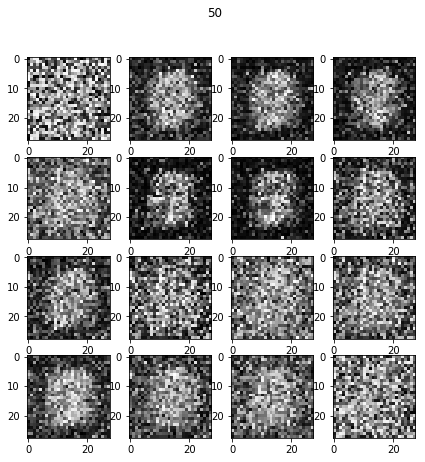

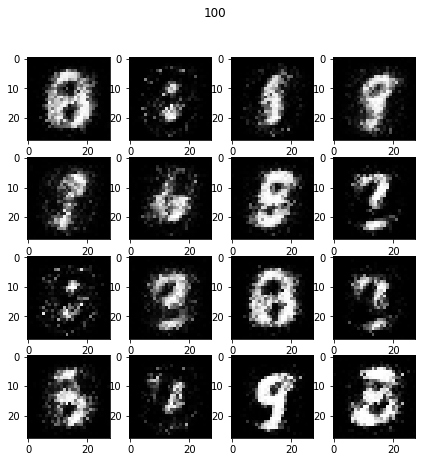

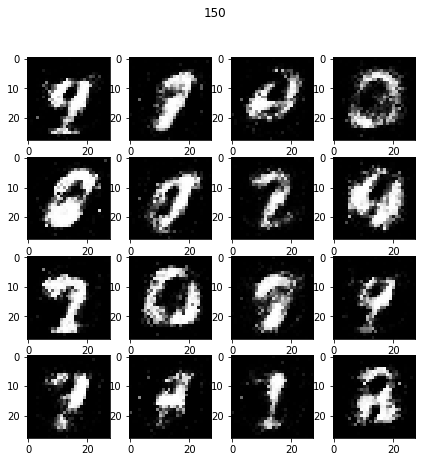

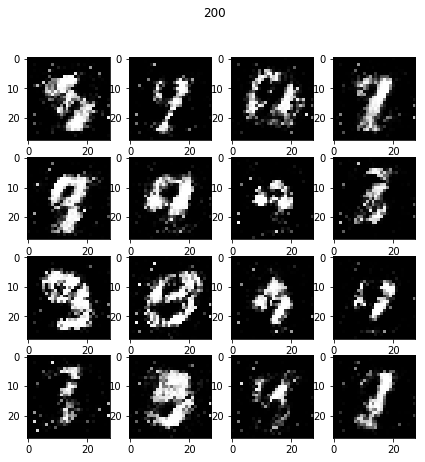

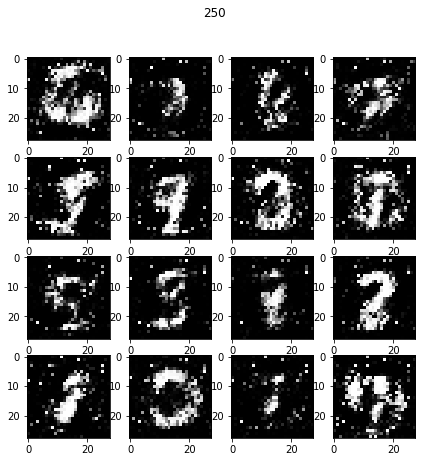

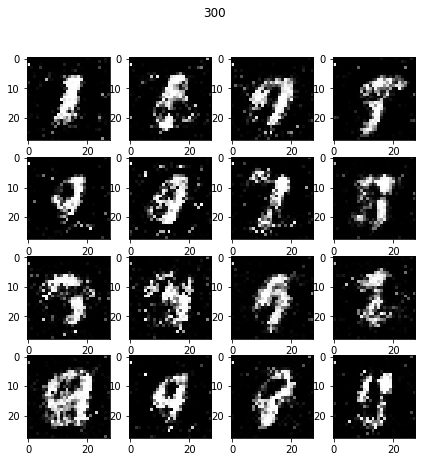

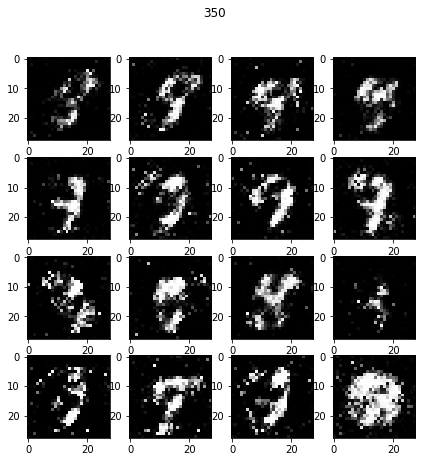

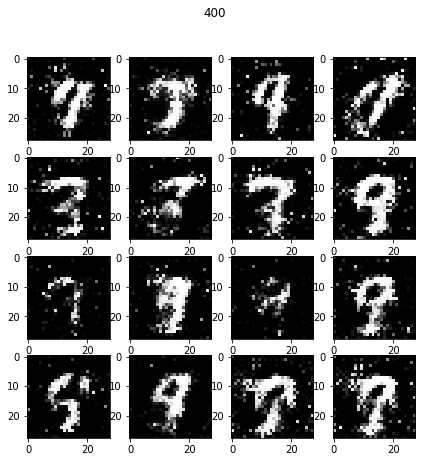

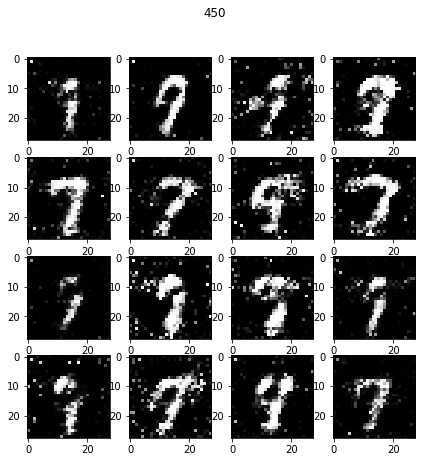

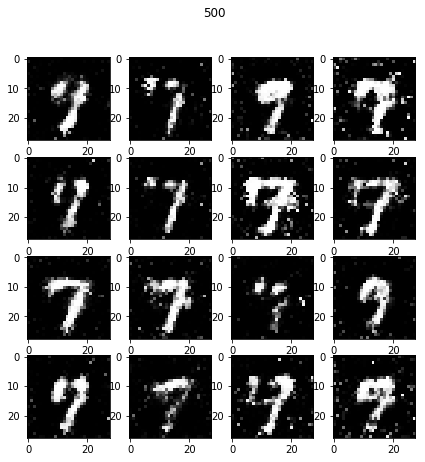

In [19]:
# 테스트 할 때 특정 레이블을 가진 새로운 데이터 샘플을 생성하려고합니다.
#예를 들어 레이블을 7로 설정합니다. 즉 "7"자릿수를 생성하려고합니다.

for epoch in range(epochs):
    total_batch=math.ceil(sample_size/batch_size) 
    # math.ceil : 소수점 이하를 버림. (5000/100) = 50
    # total_batch는 50
    
    avg_loss=0
    for ii in range(total_batch): # total_batch만큼 for문.
        if ii!=total_batch: # total_batch가 아닌 것은 
            batch_X=Xr[ii*batch_size:(ii+1)*batch_size] # ii가 0이면 0~100
            batch_Y=Yr[ii*batch_size:(ii+1)*batch_size] # 1이면 100~200              
        else:
            batch_X=Xr[(ii+1)*batch_size:] #Xr의 100*ii번째 이후
            batch_Y=Yr[(ii+1)*batch_size:] #Yr의 100*ii번째 이후
        batch_X = batch_X*2 - 1    # mnist의 기본 batch는 0~1사이의 값임. ->batch_X를 -1부터 1사이의 값으로 바꿔주기 위함.
        batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) #동일
        D_loss_curr,_ = sess.run([D_loss,D_solver], feed_dict={X:batch_X, Z: batch_z, Y: batch_Y,keep_prob:1}) #드롭아웃 1
        G_loss_curr,_ = sess.run([G_loss,G_solver], feed_dict={X:batch_X, Z: batch_z, Y:batch_Y,keep_prob:1})    
        losss=D_loss_curr+G_loss_curr
        avg_loss+=losss/total_batch #평균 로스.
    print('Epoch: %d' %(epoch+1),'Discriminator Loss= %f, Generator Loss= %f, Avg Loss=%f' %(D_loss_curr, G_loss_curr, avg_loss))   
    losses.append((D_loss_curr, G_loss_curr,avg_loss))   
    
    if (epoch+1)%50==0: # epoch 50번마다 생성한 이미지 출력.
        tf.set_random_seed(0)
        sample_z = np.random.uniform(-1, 1, size=(16,z_dim))
        sample_y = np.zeros(shape=[16, y_dim]); sample_y[:,7]=1
        gen_samples = sess.run(G_z,feed_dict={Z: sample_z,Y:sample_y})
        f,axes =plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
        f.suptitle(epoch+1)
        for ii in range(16):
            plt.subplot(4,4,ii+1)
            plt.imshow(gen_samples[ii].reshape((28,28)), cmap='Greys_r')


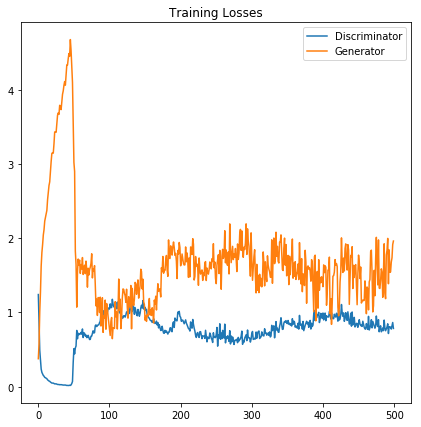

In [20]:
#판별자와 생성자 Training Losses 그래프 
fig, ax = plt.subplots(figsize=(7,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
#plt.plot(losses.T[2], label='Avg Loss')
plt.title("Training Losses")
plt.legend()